In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

/var/folders/6s/29zyjkhd39s4nfqnksw42_200000gn/T/ipykernel_1950/3630762221.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Loading

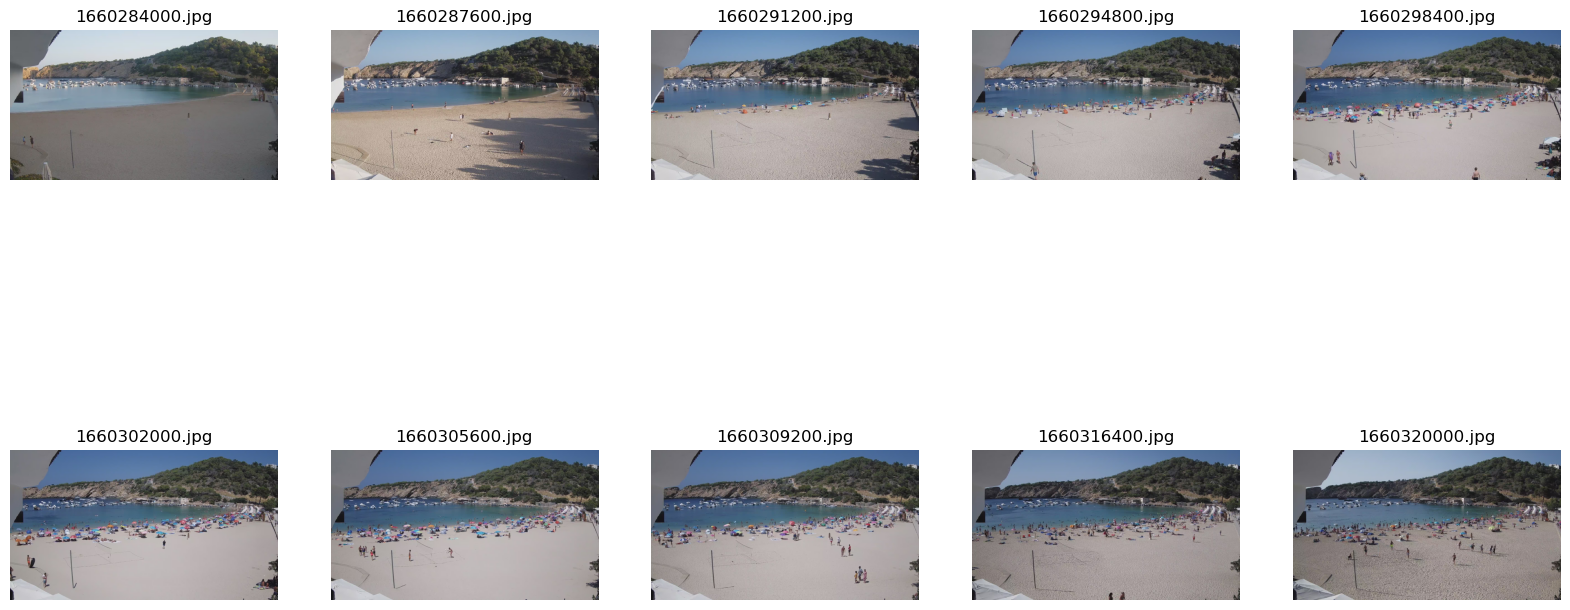

In [2]:
img_path = './data'
image_files = sorted([f for f in os.listdir(img_path) if f.endswith('.jpg')])
input_images = [cv2.imread(os.path.join(img_path, f)) for f in image_files]
image_names = image_files

fig, axes = plt.subplots(2, len(input_images) // 2, figsize=(20, 10))
for ax, img, name in zip(axes.flatten(), input_images, image_names):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(name)
    ax.axis('off')
plt.show()

In [3]:
annotations = pd.read_csv('./data/manual_annotations.csv')
annotations.head()

,label,point_x,point_y,image_name,image_width,image_height
0,Person,104,774,1660284000.jpg,1920,1080
1,Person,148,768,1660284000.jpg,1920,1080
2,Person,1458,433,1660284000.jpg,1920,1080
3,Person,18,564,1660287600.jpg,1920,1080
4,Person,43,568,1660287600.jpg,1920,1080


In [4]:
annotations.columns

Index(['label', 'point_x', 'point_y', 'image_name', 'image_width',
       'image_height'],
      dtype='object')

In [5]:
annotations['image_id'] = ['image_' + str(i) for i in pd.factorize(annotations['image_name'])[0]]
annotations.head()

,label,point_x,point_y,image_name,image_width,image_height,image_id
0,Person,104,774,1660284000.jpg,1920,1080,image_0
1,Person,148,768,1660284000.jpg,1920,1080,image_0
2,Person,1458,433,1660284000.jpg,1920,1080,image_0
3,Person,18,564,1660287600.jpg,1920,1080,image_1
4,Person,43,568,1660287600.jpg,1920,1080,image_1


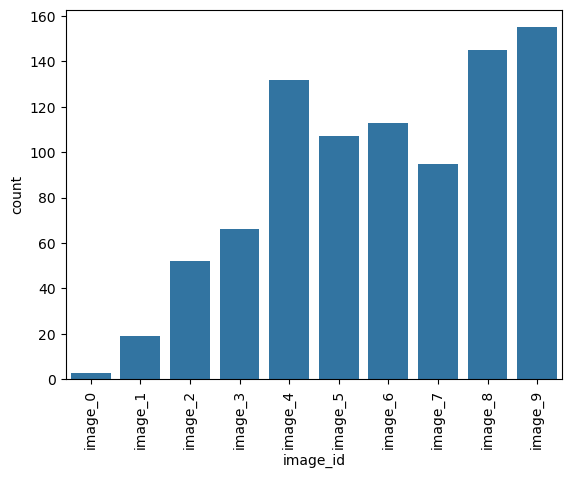

In [6]:
sns.countplot(data=annotations, x = 'image_id')
plt.xticks(rotation=90)
plt.show()

And add other useful data visualization and analysis for the images

## Algorithm

Also try to get the colour differences for images that have umbrellas. Umbrellas have colours red, pink, green etc.

In [7]:
from src.methods import get_canny_edges, rgb_distance_mask

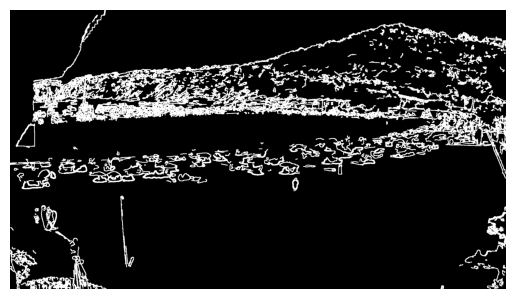

In [8]:
bel1 = get_canny_edges(input_images[5], input_images[0])

plt.imshow(bel1, cmap='gray')
plt.axis('off')
plt.show()

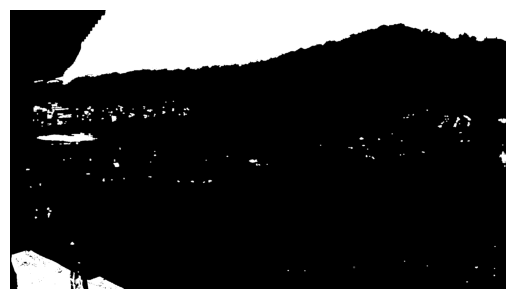

In [9]:
bel2 = rgb_distance_mask(input_images[5], input_images[0], thresh=80, morph=True)

plt.imshow(bel2, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
mask = cv2.bitwise_or(bel1, bel2)
mask = cv2.erode(mask, np.ones((3,3)))

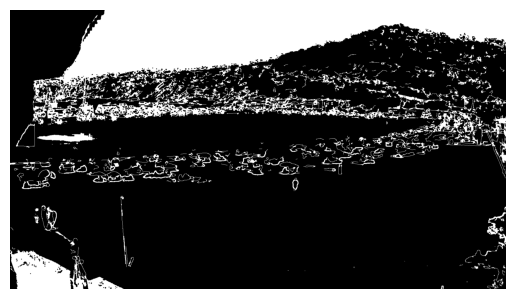

In [11]:
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

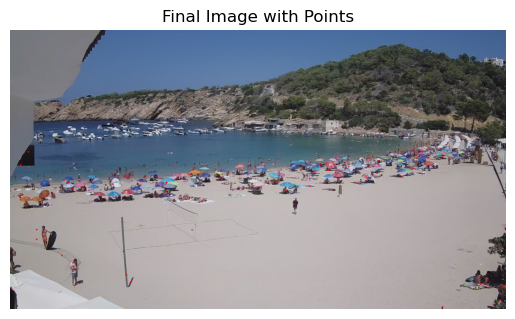

In [12]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
points = []
for i in range(1, num_labels): # Skip background label 0
    area = stats[i][cv2.CC_STAT_AREA]
    centroid = centroids[i]
        
        # Filter points based on area and y position
    if (50 < area < 1000 and 
        centroid[1] > 450):
        points.append((int(centroid[0]), int(centroid[1])))
    
    
vis_img = input_images[5].copy()
for p in points:
    cv2.circle(vis_img, p, 3, (0,0,255), -1)
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Final Image with Points')
plt.axis('off')
plt.show()

### All Images

In [13]:
all_points = []

for idx, img in enumerate(input_images[1:], start=1):
    bel1 = get_canny_edges(img, input_images[0])
    bel2 = rgb_distance_mask(img, input_images[0], thresh=80, morph=False)
    
    mask = cv2.bitwise_or(bel1, bel2)
    mask = cv2.erode(mask, np.ones((5,3)))
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    for i in range(1, num_labels):
        area = stats[i][cv2.CC_STAT_AREA]
        centroid = centroids[i]
        
        if (50 < area < 1000 and centroid[1] > 450):
            all_points.append({'point_x': int(centroid[0]), 'point_y': int(centroid[1]), 'image_id': f'image_{idx}'})

# Create a dataframe from the points
predictions_df = pd.DataFrame(all_points)

In [14]:
annotations_df = annotations[['image_id', 'point_x', 'point_y']]

### Image Level Evaluation

In [15]:
eval_df = pd.DataFrame(predictions_df['image_id'].value_counts().to_list(), columns = ['image_id'])

In [16]:
eval_df = eval_df.join(pd.DataFrame(annotations_df['image_id'].value_counts().to_list(), columns = ['image_id']), rsuffix='_gt')
eval_df = eval_df.rename(columns={'image_id': 'people', 'image_id_gt': 'people_gt'})
eval_df = eval_df.sort_index()

In [17]:
eval_df['mse'] = np.power(eval_df['people'] - eval_df['people_gt'], 2)
eval_df['error_percentage'] = np.abs(100 - np.divide(eval_df['people'], eval_df['people_gt']) * 100)

In [18]:
eval_df

,people,people_gt,mse,error_percentage
0,118,155,1369,23.870968
1,115,145,900,20.689655
2,110,132,484,16.666667
3,107,113,36,5.309735
4,105,107,4,1.869159
5,103,95,64,8.421053
6,75,66,81,13.636364
7,42,52,100,19.230769
8,31,19,144,63.157895


In [19]:
print(f"Mean MSE: {eval_df['mse'].mean()}")

Mean MSE: 353.55555555555554


### Person Level Evaluation

In [20]:
def is_within_radius(p1, p2, radius):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) <= radius

tp = {}
fn = {}
fp = {}
iou = {}
gt_v_pred = [input_images[0]]
fp_flag = 0
radius = 30  

for x, img in enumerate(annotations_df['image_id'].unique()):
    if x == 0:
        continue
    out = input_images[x].copy()
    df = annotations_df[annotations_df['image_id'] == img]
    img_points = [p for p in all_points if p['image_id'] == img]
    
    for p in img_points:
        for _, b in df.iterrows():
            fp_flag = 0
            
            if is_within_radius((b['point_x'], b['point_y']), (p['point_x'], p['point_y']), radius):
                if img not in tp:
                    tp[img] = 0
                tp[img] += 1
                cv2.circle(out, (b['point_x'], b['point_y']), radius, (127, 255, 25), 3)
                cv2.circle(out, (p['point_x'], p['point_y']), 5, (0, 0, 255), -1)
                fp_flag = 1
                break

        if fp_flag == 0:
            if img not in fp:
                fp[img] = 0
            fp[img] += 1

    gt_v_pred.append(out)

    fn[img] = df.shape[0] - tp.get(img, 0)

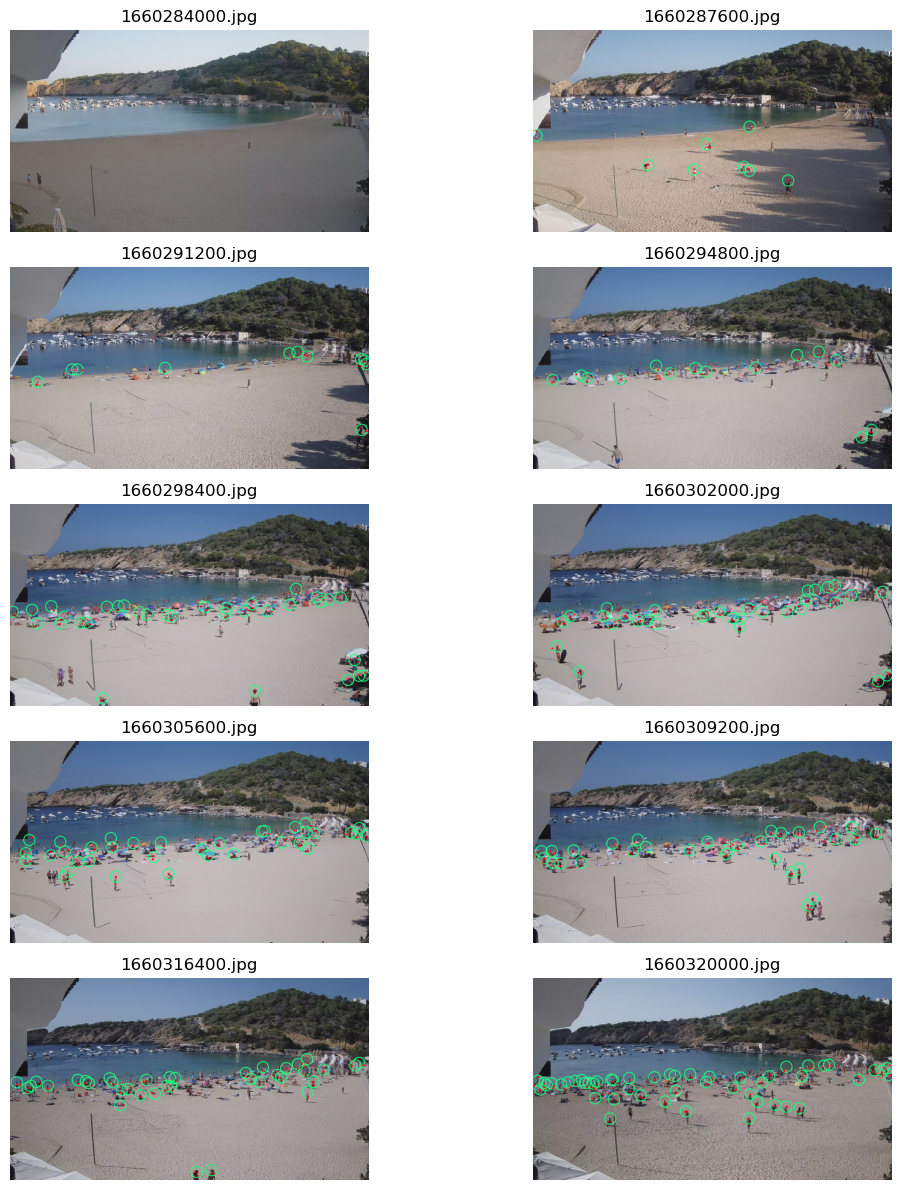

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
for ax, img, name in zip(axes.flatten(), gt_v_pred, image_names):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
# Blank

In [23]:
acc_score = pd.DataFrame([tp, fp, fn]).T
acc_score = acc_score.rename(columns={0: 'tp', 1: 'fp', 2: 'fn'})
acc_score['precision'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fp'])
acc_score['recall'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fn'])
acc_score['f1'] = 2 * (acc_score['precision'] * acc_score['recall']) / (acc_score['precision'] + acc_score['recall'])
acc_score['accuracy'] = acc_score['tp'] / (acc_score['tp'] + acc_score['fp'] + acc_score['fn'])

In [24]:
acc_score

,tp,fp,fn,precision,recall,f1,accuracy
image_1,9,22,10,0.290323,0.473684,0.360000,0.219512
image_2,14,28,38,0.333333,0.269231,0.297872,0.175000
image_3,17,58,49,0.226667,0.257576,0.241135,0.137097
image_4,44,61,88,0.419048,0.333333,0.371308,0.227979
image_5,45,70,62,0.391304,0.420561,0.405405,0.254237
image_6,45,62,68,0.420561,0.398230,0.409091,0.257143
image_7,48,55,47,0.466019,0.505263,0.484848,0.320000
image_8,50,60,95,0.454545,0.344828,0.392157,0.243902
image_9,63,55,92,0.533898,0.406452,0.461538,0.300000


In [25]:
print(f"Average precision: {acc_score['precision'].mean() * 100:.2f}%")
print(f"Average recall: {acc_score['recall'].mean() * 100:.2f}%")
print(f"Average accuracy: {acc_score['accuracy'].mean() * 100:.2f}%")
print(f"Average F1 score: {acc_score['f1'].mean() * 100:.2f}%")
print(f"Total true-positives: {acc_score['tp'].sum()}")

Average precision: 39.29%
Average recall: 37.88%
Average accuracy: 23.72%
Average F1 score: 38.04%
Total true-positives: 335


### Comparison with Deep Learning Methods

In [28]:
from ultralytics import YOLO

In [30]:
model = YOLO('yolov8m.pt')  

classes = [0]

100%|██████████| 49.7M/49.7M [00:03<00:00, 13.5MB/s]


In [52]:
yolo_preds = []

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for idx, (ax, img) in enumerate(zip(axs.flatten(), input_images[1:]), start=1):
    img_yolo = img.copy()
    img_yolo = cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB)
    results = model(img_yolo, classes=classes)
    annotated_img = results[0].plot() 
    yolo_preds.append(results[0].boxes.xywh.shape[0])
    
    ax.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

/var/folders/6s/29zyjkhd39s4nfqnksw42_200000gn/T/ipykernel_1950/87345306.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 2, figsize=(15, 30))


0: 384x640 12 persons, 206.5ms
Speed: 4.4ms preprocess, 206.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 209.2ms
Speed: 1.4ms preprocess, 209.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 139.0ms
Speed: 2.1ms preprocess, 139.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 140.5ms
Speed: 1.4ms preprocess, 140.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 146.6ms
Speed: 1.8ms preprocess, 146.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 136.6ms
Speed: 1.6ms preprocess, 136.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 157.6ms
Speed: 1.4ms preprocess, 157.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 164.1ms
Speed: 1.9ms preprocess, 164.1ms inference, 0.7ms postprocess pe

In [53]:
eval_df['yolo'] = yolo_preds
eval_df['yolo_mse'] = np.power(eval_df['yolo'] - eval_df['people_gt'], 2)

In [54]:
eval_df

,people,people_gt,mse,error_percentage,yolo,yolo_mse
0,118,155,1369,23.870968,12,20449
1,115,145,900,20.689655,6,19321
2,110,132,484,16.666667,5,16129
3,107,113,36,5.309735,12,10201
4,105,107,4,1.869159,5,10404
5,103,95,64,8.421053,7,7744
6,75,66,81,13.636364,9,3249
7,42,52,100,19.230769,11,1681
8,31,19,144,63.157895,12,49


In [55]:
print(f"Mean MSE: {eval_df['yolo_mse'].mean()}")

Mean MSE: 9914.111111111111
